<a href="https://colab.research.google.com/github/Pumafi/problem_solving_rl_pumafi/blob/main/initial_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ARC-AGI

Ferdinand Bhavsar

PhD student, Mines Paris

In [1]:
RUNNING_IN_COLAB = True

%cd /content

if RUNNING_IN_COLAB:
    REPO_URL = 'https://github.com/Pumafi/problem_solving_rl_pumafi'
    BRANCH   = 'main'
    REPO_DIR = 'problem_solving_rl_pumafi'

    from pathlib import Path

    if Path(REPO_DIR).is_dir():
      !rm -rf {REPO_DIR}

    # Download the repository
    if not Path(REPO_DIR).is_dir():
        !git clone --branch {BRANCH} --depth=1 -- {REPO_URL} {REPO_DIR}

    %cd {REPO_DIR}

/content
Cloning into 'problem_solving_rl_pumafi'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 395.15 KiB | 1.85 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/problem_solving_rl_pumafi


### Imports

In [2]:
from tensorflow import keras
import pandas as pd
import numpy as np

import random
import math
from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
from matplotlib import colors


from scipy.stats import kde
from sklearn.metrics.pairwise import euclidean_distances

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras import layers, losses
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

In [53]:
# Load code from the repo
from utils.data_handling import get_color_map, pad_to_shape, preprocess_challenge_data
from utils.noising_grids import create_fail

### Utilities

Get color map (took from some random code I had lying around, so the colors are not the ones from ARC-AGI

### Dataset Loading

In [4]:
import json

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

training_challenges = load_json('./data/arc-agi_training_challenges.json')
training_solutions = load_json('./data/arc-agi_training_solutions.json')
evaluation_challenges = load_json('./data/arc-agi_evaluation_challenges.json')

print("Data loaded successfully.")
print(f"Training tasks: {len(training_challenges)}")
print(f"Evaluation tasks: {len(evaluation_challenges)}")

Data loaded successfully.
Training tasks: 400
Evaluation tasks: 400


Preprocess the challenge data (I'm not touching the indentation, it was a nightmare of using jupyter AND colab for some tests)

In [31]:
challenge_propositioner_inputs, train_solver_inputs, train_solver_outputs, test_solver_inputs, test_solver_outputs = preprocess_challenge_data(training_challenges, training_solutions)
print(len(challenge_propositioner_inputs), len(train_solver_inputs), len(train_solver_outputs), len(test_solver_inputs), len(test_solver_outputs))

400 400 400 400 400


In [32]:
# visualize data types
print(type(challenge_propositioner_inputs))
print(type(challenge_propositioner_inputs[0]))
print(type(challenge_propositioner_inputs[0][0]))
print(type(challenge_propositioner_inputs[0][0][0]))

<class 'list'>
<class 'list'>
<class 'tuple'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [33]:
# In order of access we have:
#     challenge_propositioner_inputs [problem_nb (list)] [example_nb (list)] [0/1 - input/output (tuple)] -> [30, 30, 10] (ndarray)

# Visualize the size of examples sets (NB: All have at least 2 examples, but 2 is to few for my idea)
for i in range(5):
  print("Problem nb ", i +1, " | nb examples: ", len(challenge_propositioner_inputs[i]))

print("\nSize of one grid: ", challenge_propositioner_inputs[0][0][0].shape)

Problem nb  1  | nb examples:  5
Problem nb  2  | nb examples:  5
Problem nb  3  | nb examples:  3
Problem nb  4  | nb examples:  2
Problem nb  5  | nb examples:  3

Size of one grid:  (30, 30, 10)


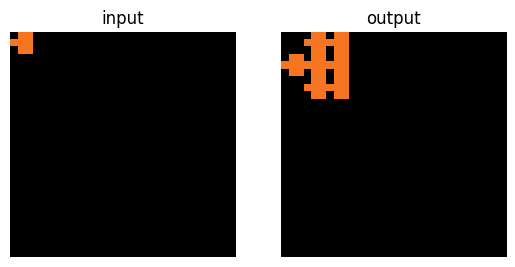

In [34]:
cmap, norm = get_color_map(number_of_categories=9)

plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(np.argmax(challenge_propositioner_inputs[0][0][0], axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('output')
plt.imshow(np.argmax(challenge_propositioner_inputs[0][0][1], axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
plt.axis('off')
plt.show()

In [35]:
# Idea: create sub-array of fixed sized with success/fail examples
# [X] 1) create a fail function that creates failes examples (random noise & rotation & color translation& random selection)
# [X] 2) Remove the challenges with only two examples (we want at least 2 success)
# [X] 3) Split challenges with more than 6 examples (6 into 3/3, 7 into 4/3, 8 into 4/4, 9 into 5/4, 10 into 4/3/3)
# [X] 4) Isolate for each task 2 successes
# [ ] 5) The rest has to be completed with failure

In [36]:
#def create_fail(challenge_grids):
#    ...
#    return challenge_grids, labels

In [54]:
tmp_test_structure = challenge_propositioner_inputs[3].copy()
tmp_output_test, labels = create_fail(tmp_test_structure)

print(len(challenge_propositioner_inputs[3]), len(tmp_output_test))

2 4


In [60]:
def split_list(lst):
    if len(lst) <= 2:
        return []  # Remove lists with 1 or 2 elements
    if len(lst) <= 6:
        return [lst]
    split_sizes = {6: [3, 3], 7: [4, 3], 8: [4, 4], 9: [5, 4], 10: [4, 3, 3]}

    if len(lst) in split_sizes:
        sizes = split_sizes[len(lst)]
        parts = []
        index = 0
        for size in sizes:
            parts.append(lst[index:index + size])
            index += size
        return parts
    else:
        # General case for lists >10: split into chunks of 4 or 5 alternately
        parts = []
        index = 0
        toggle = True  # Alternate between 4 and 5
        while len(lst) - index > 5:
            parts.append(lst[index:index + (4 if toggle else 5)])
            index += 4 if toggle else 5
            toggle = not toggle
        parts.append(lst[index:])  # Add the remaining part
        return parts


def process_inputs(inputs):
    filtered_and_split = []
    for sublist in inputs:
        if len(sublist) > 1:  # Remove lists with 1 or 2 elements
            filtered_and_split.extend(split_list(sublist))
    return filtered_and_split

# Example usage:
# Assuming challenge_propositioner_inputs is defined
processed_inputs = process_inputs(challenge_propositioner_inputs)

# Print results
for i, lst in enumerate(processed_inputs):
    print(f"Processed list {i+1} | Size: {len(lst)}")


Processed list 1 | Size: 5
Processed list 2 | Size: 5
Processed list 3 | Size: 3
Processed list 4 | Size: 3
Processed list 5 | Size: 3
Processed list 6 | Size: 3
Processed list 7 | Size: 3
Processed list 8 | Size: 3
Processed list 9 | Size: 4
Processed list 10 | Size: 4
Processed list 11 | Size: 3
Processed list 12 | Size: 3
Processed list 13 | Size: 4
Processed list 14 | Size: 3
Processed list 15 | Size: 3
Processed list 16 | Size: 4
Processed list 17 | Size: 3
Processed list 18 | Size: 3
Processed list 19 | Size: 3
Processed list 20 | Size: 3
Processed list 21 | Size: 3
Processed list 22 | Size: 3
Processed list 23 | Size: 5
Processed list 24 | Size: 3
Processed list 25 | Size: 3
Processed list 26 | Size: 3
Processed list 27 | Size: 3
Processed list 28 | Size: 3
Processed list 29 | Size: 3
Processed list 30 | Size: 4
Processed list 31 | Size: 3
Processed list 32 | Size: 3
Processed list 33 | Size: 3
Processed list 34 | Size: 3
Processed list 35 | Size: 3
Processed list 36 | Size: 3
P

In [61]:
def split_into_two_lists(processed_inputs):
    list_of_pairs = []
    remaining_list = []

    for sublist in processed_inputs:
        if len(sublist) >= 2:
            pair = sublist[:2]  # Extract only the first pair
            remainder = sublist[2:]  # Remaining elements after extracting one pair
            list_of_pairs.append(pair)
            if remainder:
                remaining_list.append(remainder)

    return list_of_pairs, remaining_list

# Example usage:
processed_inputs = process_inputs(challenge_propositioner_inputs)
list_of_pairs, remaining_list = split_into_two_lists(processed_inputs)

# Print results
print("List of pairs:")
for i, lst in enumerate(list_of_pairs):
    print(f"Pair {i+1} | Size: {len(lst)}")

print("\nRemaining list:")
for i, lst in enumerate(remaining_list):
    print(f"Remaining {i+1} | Size: {len(lst)}")


List of pairs:
Pair 1 | Size: 2
Pair 2 | Size: 2
Pair 3 | Size: 2
Pair 4 | Size: 2
Pair 5 | Size: 2
Pair 6 | Size: 2
Pair 7 | Size: 2
Pair 8 | Size: 2
Pair 9 | Size: 2
Pair 10 | Size: 2
Pair 11 | Size: 2
Pair 12 | Size: 2
Pair 13 | Size: 2
Pair 14 | Size: 2
Pair 15 | Size: 2
Pair 16 | Size: 2
Pair 17 | Size: 2
Pair 18 | Size: 2
Pair 19 | Size: 2
Pair 20 | Size: 2
Pair 21 | Size: 2
Pair 22 | Size: 2
Pair 23 | Size: 2
Pair 24 | Size: 2
Pair 25 | Size: 2
Pair 26 | Size: 2
Pair 27 | Size: 2
Pair 28 | Size: 2
Pair 29 | Size: 2
Pair 30 | Size: 2
Pair 31 | Size: 2
Pair 32 | Size: 2
Pair 33 | Size: 2
Pair 34 | Size: 2
Pair 35 | Size: 2
Pair 36 | Size: 2
Pair 37 | Size: 2
Pair 38 | Size: 2
Pair 39 | Size: 2
Pair 40 | Size: 2
Pair 41 | Size: 2
Pair 42 | Size: 2
Pair 43 | Size: 2
Pair 44 | Size: 2
Pair 45 | Size: 2
Pair 46 | Size: 2
Pair 47 | Size: 2
Pair 48 | Size: 2
Pair 49 | Size: 2
Pair 50 | Size: 2
Pair 51 | Size: 2
Pair 52 | Size: 2
Pair 53 | Size: 2
Pair 54 | Size: 2
Pair 55 | Size: 2
Pair